# Exploration des mots

## Définition des constantes

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from lxml import etree  # pour la fonction get_words_from_xml_form()
import glob  # pour la fonction get_files()
from collections import Counter


In [3]:
words_meta_filename = "../data/ascii/words.txt"
forms_meta_filename = "../data/ascii/forms.txt"
xml_files_path = "../data/xml"

BASE_IMG_PATH = '../data/words'
columns= ['word_id', 'seg_res', 'gray_level', 'x', 'y', 'w', 'h', 'tag', 'transcription']

## Preprocessing

### Lecture des données

In [4]:
def parse_my_file(filename):
    with open(filename) as f:
        for line in f:
            if line.startswith('#'):
                continue
            yield line.strip().split(' ',len(columns) - 1)

df = pd.DataFrame(parse_my_file(words_meta_filename), columns=columns)
df.head()

word_id seg_res gray_level     x    y    w   h  tag transcription
0  a01-000u-00-00      ok        154   408  768   27  51   AT             A
1  a01-000u-00-01      ok        154   507  766  213  48   NN          MOVE
2  a01-000u-00-02      ok        154   796  764   70  50   TO            to
3  a01-000u-00-03      ok        154   919  757  166  78   VB          stop
4  a01-000u-00-04      ok        154  1185  754  126  61  NPT           Mr.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115320 entries, 0 to 115319
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   word_id        115320 non-null  object
 1   seg_res        115320 non-null  object
 2   gray_level     115320 non-null  object
 3   x              115320 non-null  object
 4   y              115320 non-null  object
 5   w              115320 non-null  object
 6   h              115320 non-null  object
 7   tag            115320 non-null  object
 8   transcription  115320 non-null  object
dtypes: object(9)
memory usage: 7.9+ MB


In [6]:
df['seg_res'].value_counts()

ok     96456
err    18864
Name: seg_res, dtype: int64

In [7]:
df['x'] = df['x'].astype(int)
df['y'] = df['y'].astype(int)
df['w'] = df['w'].astype(int)
df['h'] = df['h'].astype(int)
df['seg_res'].replace(['ok', 'err'], [1, 0], inplace=True) 
df['gray_level'] = df['gray_level'].astype(int)


In [8]:
print('Le dataset dispose de ' + str(df.shape[0]) +' mots scannés.')
print('Le dataset dispose de ' + str(df['seg_res'].value_counts()[1]) +' mots avec segmentation OK.')

Le dataset dispose de 115320 mots scannés.
Le dataset dispose de 96456 mots avec segmentation OK.


In [9]:
def get_word_image_path_by_word_id(word_id):
    path_parts = word_id.split('-')
    return BASE_IMG_PATH + '/' + path_parts[0] + '/' + "-".join(path_parts[0:2]) + '/' + word_id+ '.png'

def get_form_img_path_by_word_id(word_id):
    path_parts = word_id.split('-')
    first_letter = path_parts[0][0].lower()
    if first_letter in ['a', 'b', 'c', 'd']:
        base_path = "../data/formsA-D/" 
    elif first_letter in ['e', 'f', 'g', 'h']:
        base_path = "../data/formsE-H/" 
    else:
        base_path = "../data/formsI-Z/" 
    return base_path + "-".join(path_parts[0:2]) + '.png'

In [10]:
df['word_img_path'] = df['word_id'].apply(lambda x: get_word_image_path_by_word_id(x))
df['form_img_path'] = df['word_id'].apply(lambda x: get_form_img_path_by_word_id(x))

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115320 entries, 0 to 115319
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   word_id        115320 non-null  object
 1   seg_res        115320 non-null  int64 
 2   gray_level     115320 non-null  int64 
 3   x              115320 non-null  int64 
 4   y              115320 non-null  int64 
 5   w              115320 non-null  int64 
 6   h              115320 non-null  int64 
 7   tag            115320 non-null  object
 8   transcription  115320 non-null  object
 9   word_img_path  115320 non-null  object
 10  form_img_path  115320 non-null  object
dtypes: int64(6), object(5)
memory usage: 9.7+ MB


In [12]:
df.head()

word_id  seg_res  gray_level     x    y    w   h  tag transcription  \
0  a01-000u-00-00        1         154   408  768   27  51   AT             A   
1  a01-000u-00-01        1         154   507  766  213  48   NN          MOVE   
2  a01-000u-00-02        1         154   796  764   70  50   TO            to   
3  a01-000u-00-03        1         154   919  757  166  78   VB          stop   
4  a01-000u-00-04        1         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png   

                   form_img_path  
0  ../data/formsA-D/a01-000u.png  
1  ../data/formsA-D/a01-000u.png  
2  ../data/formsA-D/a01-000u.png  
3  ../data/formsA-D/a01-000u.png  
4  ../data/formsA-D/a01-000u.png

## Rendering

### Affichage des mots

In [13]:

def show_img(path):
    img = plt.imread(path)
    plt.figure(figsize = (20,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')


def show_word_image_by_line(line):
    show_img(line.word_img_path)


def show_form_img_by_word_id(line):
    show_img(line.form_img_path)

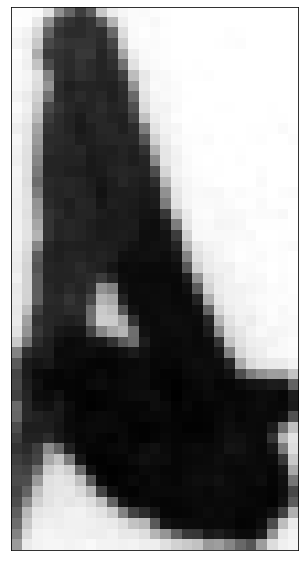

In [14]:
show_word_image_by_line(df.iloc[0])

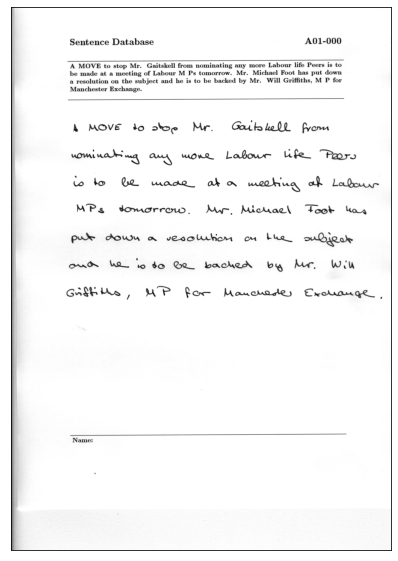

In [15]:
show_form_img_by_word_id(df.iloc[0])

### Affichage des contours sur les forms

In [16]:
def plot_bounding_box(line):
    img = plt.imread(line.form_img_path)

    fig, ax = plt.subplots(figsize=(20,15))
    fig.figsize=(20,10)
    ax.imshow(img, cmap='gray')

    ax.add_patch(
        patches.Rectangle(
            (line.x-8, line.y-8),
            line.w+16,
            line.h+16,
            fill=False,
            color = 'red'      
        ) ) 
    plt.axis('off')
    plt.show()

def show_img_ax(path,ax):
    img = plt.imread(path)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img, cmap='gray')

def show_word_image_by_line_ax(line,ax):
    show_img_ax(line.word_img_path,ax)

def show_form_img_by_word_id_ax(line,ax):
    show_img_ax(line.form_img_path,ax)
    
def plot_bounding_box_ax(line,ax):
    img = plt.imread(line.form_img_path)

    ax.imshow(img, cmap='gray')

    ax.add_patch(
        patches.Rectangle(
            (line.x-8, line.y-8),
            line.w+16,
            line.h+16,
            fill=False,
            color = 'red'
        ) ) 
    ax.set_xticks([])
    ax.set_yticks([])



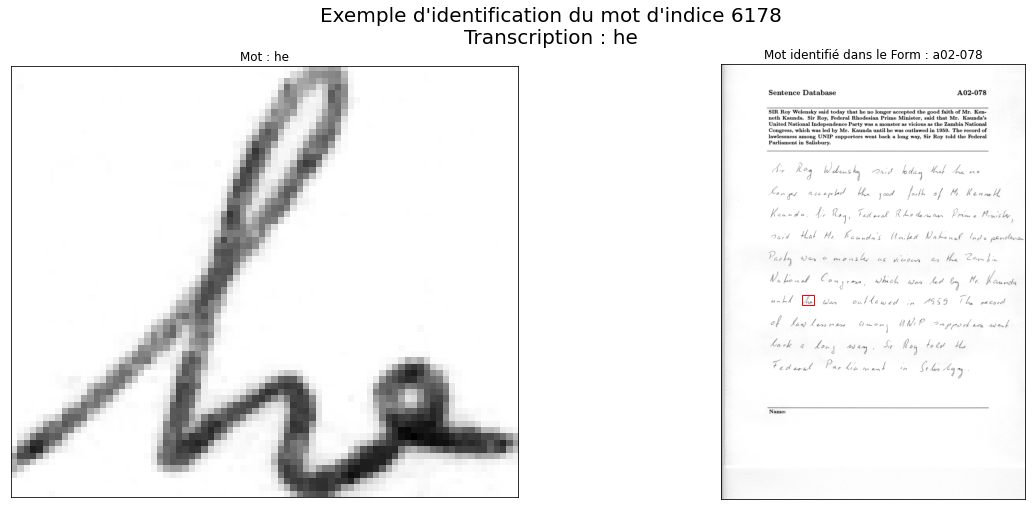

In [17]:
indice = np.random.randint(0, df.shape[0])


def plot_bounding_box_with_form(indice):    
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(121)
    ax1.set_title('Mot : '+ str(df.transcription[indice]))
    show_word_image_by_line_ax(df.iloc[indice],ax1)

    ax2 = fig.add_subplot(122)
    ax2.set_title('Mot identifié dans le Form : '+ str(df.word_id[indice][0:7]))
    plot_bounding_box_ax(df.iloc[indice],ax2)

    fig.suptitle('Exemple d\'identification du mot d\'indice ' + str(indice) +'\nTranscription : '+ str(df.transcription[indice]), fontsize=20);

plot_bounding_box_with_form(indice)

### Représentation globale du dataset

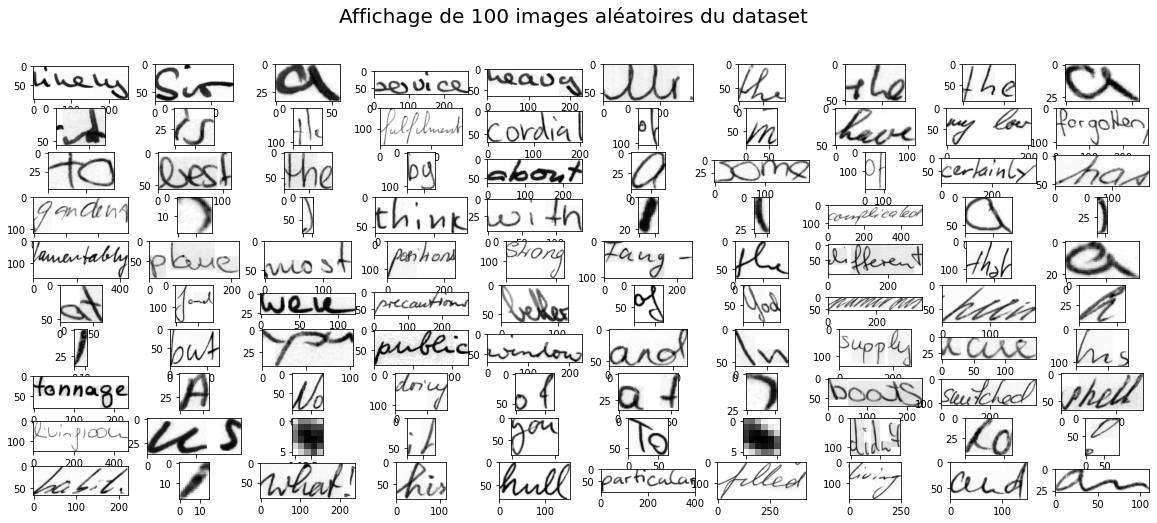

In [18]:
n_lignes = 10
n_colonnes = 10
n_images = n_lignes * n_colonnes

# génération d'une liste d'index aléatoires
rand_list = np.sort(np.random.randint(0, df.shape[0],n_images))

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df.word_id.iloc[rand_list[i]])), cmap = 'gray') ;

fig.suptitle(t = 'Affichage de ' + str(n_images) + ' images aléatoires du dataset', fontsize = 20);

## Contraste

In [19]:
import cv2
import numpy as np


def get_michelson_contrast(img_path):
    """
        Retourne le contraste de Michelson pour un chemin d'image donné
        Les valeurs possibles sont comprises entre 0 et 1 et vaut -1 en cas d'erreur
    """
    try:
        img = cv2.imread(img_path)
        Y = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0]
    except Exception:
        return -1
    min = int(np.min(Y))
    max = int(np.max(Y))
    if min == 0 and max == 0:
        return 0 
    return ((max - min) / (min + max))

df['michelson_contrast'] = df['word_img_path'].apply(lambda x: get_michelson_contrast(x))

In [20]:
df['michelson_contrast'].describe()
df[df['michelson_contrast'] == -1]

word_id  seg_res  gray_level    x     y    w   h tag  \
4152    a01-117-05-02        1         160  868  1648  217  86  NP   
113621  r06-022-03-05        1         184  924  1304  132  29  QL   

       transcription                                word_img_path  \
4152          Powell  ../data/words/a01/a01-117/a01-117-05-02.png   
113621          more  ../data/words/r06/r06-022/r06-022-03-05.png   

                       form_img_path  michelson_contrast  
4152    ../data/formsA-D/a01-117.png                -1.0  
113621  ../data/formsI-Z/r06-022.png                -1.0

Lorsque l'on essaie d'ouvrir ces deux images, une erreur se produit. Les images semblent donc corrompues, nous pouvons les effacer du dataset.

In [21]:
df = df[df['michelson_contrast'] != -1]
df['michelson_contrast'].describe()

count    115318.000000
mean          0.699827
std           0.102718
min           0.000000
25%           0.650485
50%           0.717172
75%           0.764706
max           1.000000
Name: michelson_contrast, dtype: float64

In [22]:
bad_contrast_df = df[df['michelson_contrast'] == 0]
bad_contrast_df.head()

word_id  seg_res  gray_level  x  y  w  h tag transcription  \
1418   a01-030-01-04        0         176 -1 -1 -1 -1  IN            at   
1468   a01-030-05-09        0         176 -1 -1 -1 -1   ,             ,   
2313   a01-053-08-02        0         152 -1 -1 -1 -1  TO            to   
2410  a01-053x-01-04        0         175 -1 -1 -1 -1  IN            by   
5139   a02-017-03-02        0         187 -1 -1 -1 -1   )             )   

                                      word_img_path  \
1418    ../data/words/a01/a01-030/a01-030-01-04.png   
1468    ../data/words/a01/a01-030/a01-030-05-09.png   
2313    ../data/words/a01/a01-053/a01-053-08-02.png   
2410  ../data/words/a01/a01-053x/a01-053x-01-04.png   
5139    ../data/words/a02/a02-017/a02-017-03-02.png   

                      form_img_path  michelson_contrast  
1418   ../data/formsA-D/a01-030.png                 0.0  
1468   ../data/formsA-D/a01-030.png                 0.0  
2313   ../data/formsA-D/a01-053.png                 0.0  
2410  ../data/formsA-D/a01-053x.png                 0.0  
5139   ../data/formsA-D/a02-017.png                 0.0

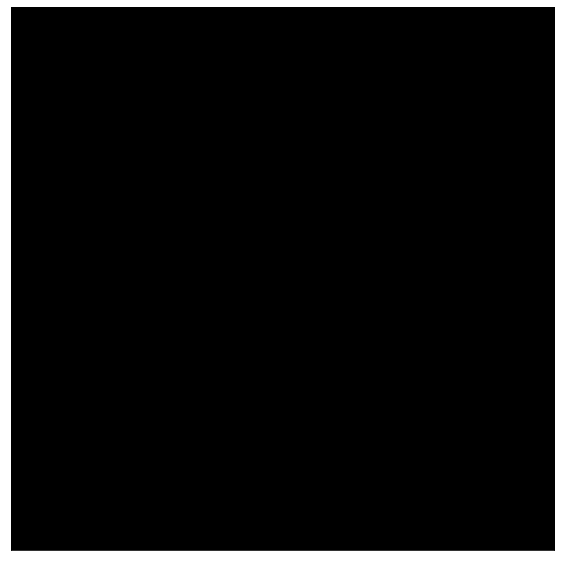

In [23]:
show_word_image_by_line(bad_contrast_df.iloc[0])


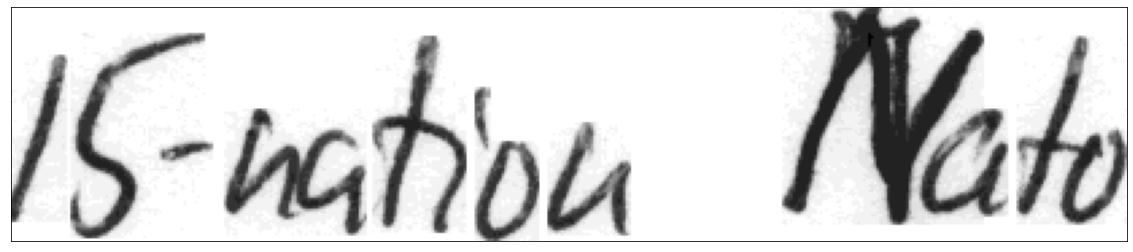

In [24]:
show_word_image_by_line(df[df['michelson_contrast'] == 1].iloc[0])

Nous remarquons des images inexploitables (contraste = 0) que nous pouvons retirer du dataset.

In [25]:
len(df)

115318

In [26]:
len(df[df['michelson_contrast'] > 0])

115186

In [27]:
df = df[df['michelson_contrast'] > 0]
df['michelson_contrast'].describe()

count    115186.000000
mean          0.700629
std           0.100006
min           0.085000
25%           0.650485
50%           0.717172
75%           0.764706
max           1.000000
Name: michelson_contrast, dtype: float64

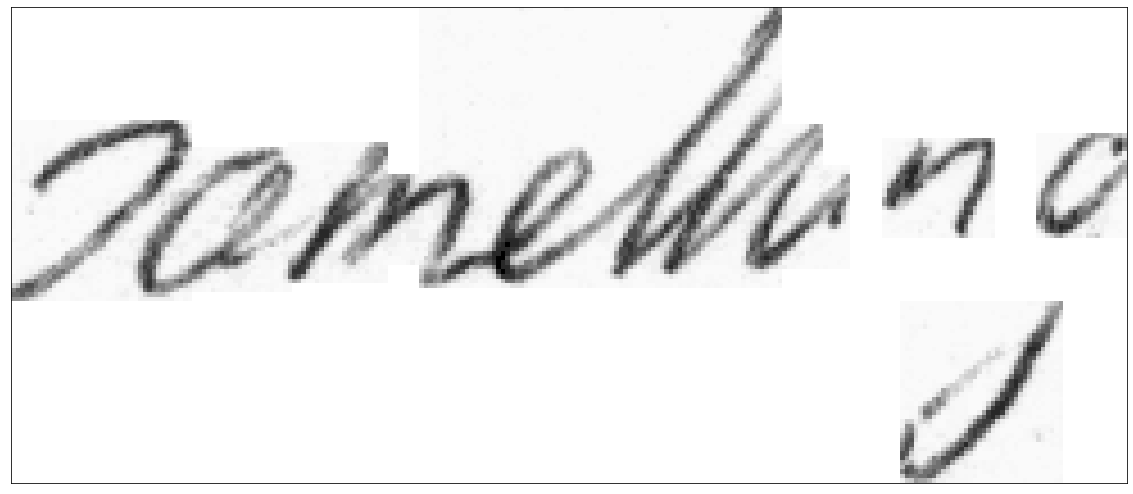

In [28]:
df[df['michelson_contrast'] == df['michelson_contrast'].min()]
show_word_image_by_line(df.iloc[47273])

L'image au contraste le plus petit reste lisible, nous pouvons ainsi considérer les autres images comme lisibles.

## Niveau de gris

### Niveau de gris des lignes

<span style="color: red">
le gray_level correspond au gray_level de la ligne scannée et pas celui du mot
</span>

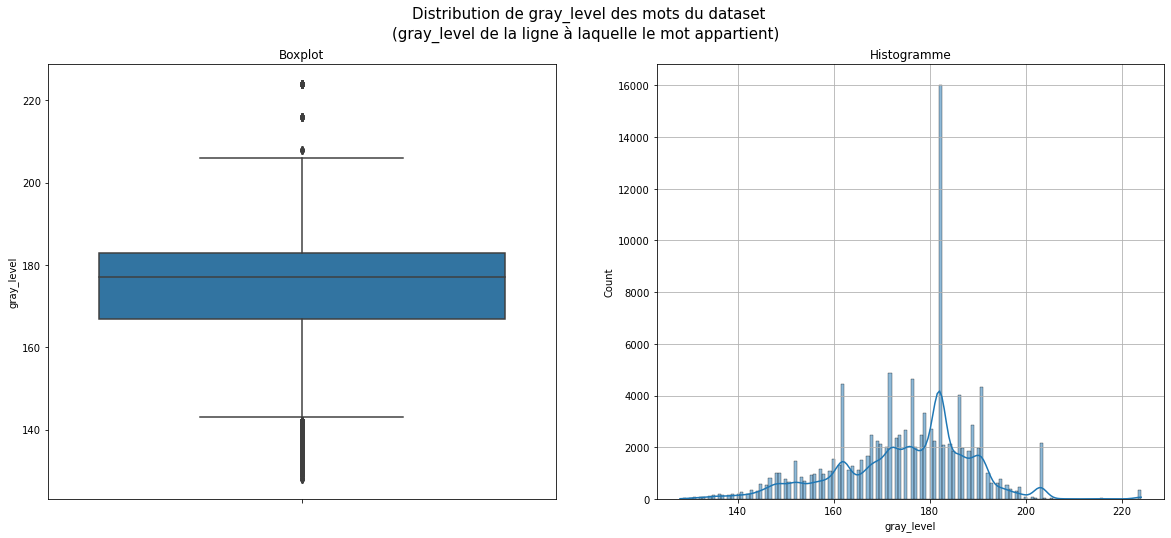

In [29]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1.set_title('Boxplot')
sns.boxplot(y='gray_level', data=df);

ax2 = fig.add_subplot(122)
sns.histplot(data = df, x= 'gray_level', kde = True)
ax2.set_title('Histogramme')
plt.grid()

fig.suptitle('Distribution de gray_level des mots du dataset\n(gray_level de la ligne à laquelle le mot appartient) ', fontsize=15);

Nous remarquons une concentration des niveaux de gris autour de la médiane (177) avec une déviation moyenne standard légère (seulement 13.8). 

Nous pouvons ainsi nous poser la question suivante: comment réagira notre modèle en présence de valeurs extrêmes traits légers aux couleurs claires et traits épaix aux couleurs sombres.

In [30]:
min_gray_level = df['gray_level'].min()
max_gray_level = df['gray_level'].max()

low_gray_level_line_index = df[df['gray_level'] == min_gray_level].index.tolist()[0]
high_gray_level_line_index = df[df['gray_level'] == max_gray_level].index.tolist()[0]

low_gray_form_img_path =  df.iloc[low_gray_level_line_index].form_img_path
low_gray_letter_img_path = df.iloc[low_gray_level_line_index].word_img_path

high_gray_form_img_path = df.iloc[high_gray_level_line_index].form_img_path
high_gray_letter_img_path = df.iloc[high_gray_level_line_index].word_img_path

low_gray_form_img = plt.imread(low_gray_form_img_path)
low_gray_letter_img = plt.imread(low_gray_letter_img_path)

high_gray_form_img = plt.imread(high_gray_form_img_path)
high_gray_letter_img = plt.imread(high_gray_letter_img_path)

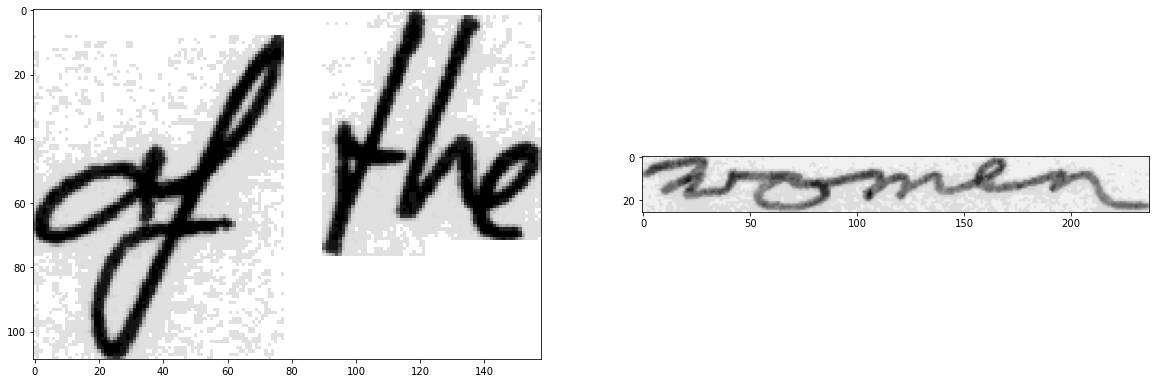

In [31]:
fig,ax = plt.subplots(1, 2, figsize = (20,10))

ax = ax.ravel()
ax[0].imshow(low_gray_letter_img, cmap='gray')
ax[1].imshow(high_gray_letter_img, cmap='gray')
plt.show()

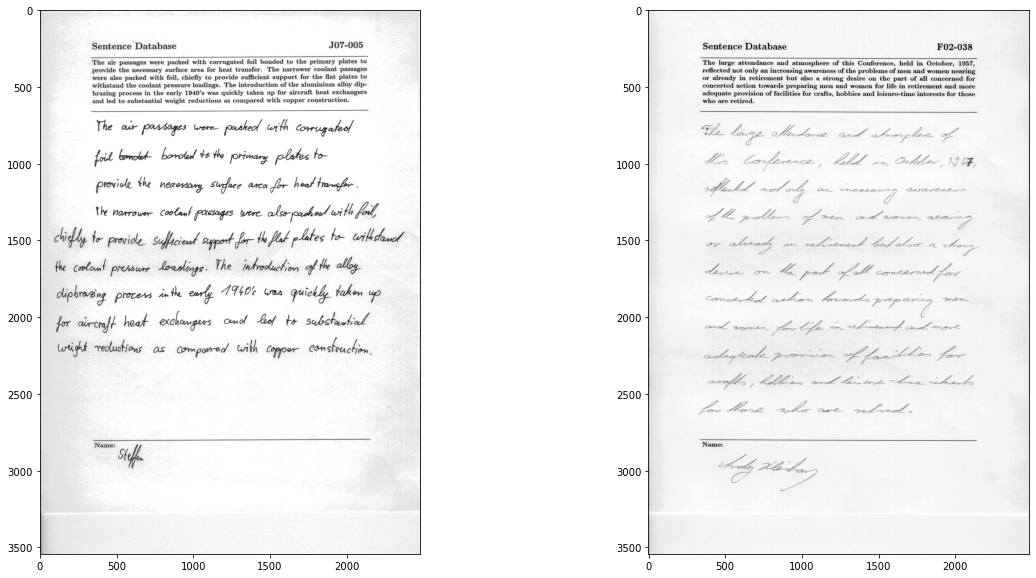

In [32]:
fig,ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].imshow(low_gray_form_img, cmap='gray')
ax[1].imshow(high_gray_form_img, cmap='gray')
plt.show()

Les images du dataset sont toutes réalisées dans de bonnes conditions pour ce qui est du contraste entre le texte et le fond. Il n'y a pas de reliefs, de couleurs ou de motifs pouvant rendre l'extraction de texte difficile.

### Affichage global

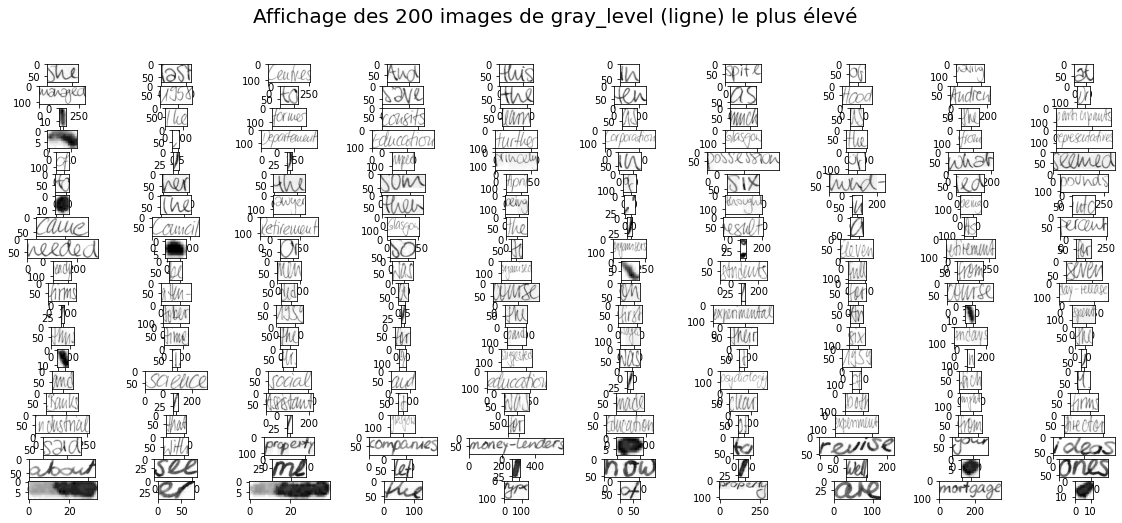

In [33]:
n_lignes = 20
n_colonnes = 10
n_images = n_lignes * n_colonnes

df_temp = df[df.seg_res==1].sort_values(by='gray_level', ascending = False, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de gray_level (ligne) le plus élevé', fontsize = 20);

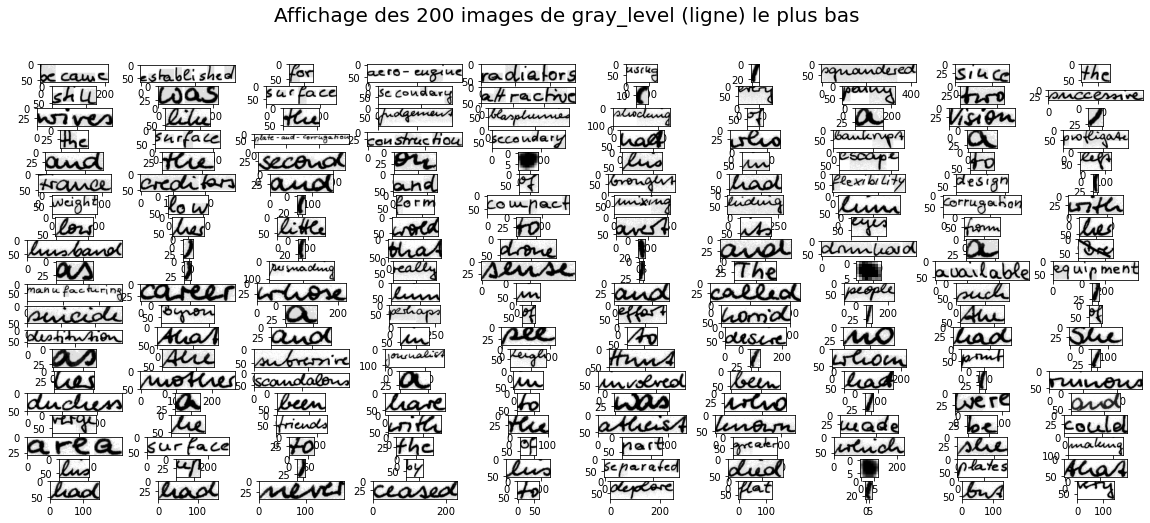

In [34]:
n_lignes = 20
n_colonnes = 10
n_images = n_lignes * n_colonnes

df_temp = df[df.seg_res==1].sort_values(by='gray_level', ascending = True, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de gray_level (ligne) le plus bas', fontsize = 20);

### Niveau de gris d'un mot

La moyenne gray_scale est de : 0.87117934


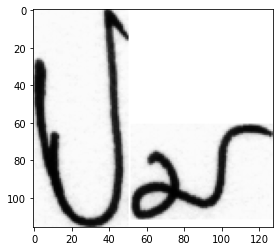

In [35]:
rand_index = np.random.randint(0, df.shape[0],1)

image = plt.imread(get_word_image_path_by_word_id(df.iloc[rand_index[0]].word_id))  
plt.imshow(image, cmap='gray')

print('La moyenne gray_scale est de :', str(image.mean()))

In [36]:
%%time

def get_img_mean(id):
    image = plt.imread(get_word_image_path_by_word_id(id))
    return image.mean()

df['gray_level_mot'] = df.word_id.apply(get_img_mean)

CPU times: user 30.8 s, sys: 4.17 s, total: 35 s
Wall time: 51.1 s


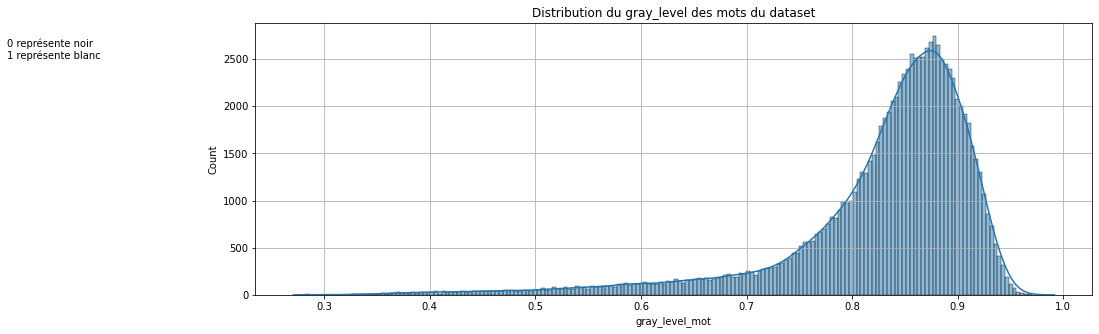

In [37]:
plt.figure(figsize = (15,5))
sns.histplot(data = df[df.seg_res==1], x= 'gray_level_mot', kde = True)
plt.title('Distribution du gray_level des mots du dataset')
plt.grid()
plt.text(0,2500,'0 représente noir\n1 représente blanc');

#### Représentation globale

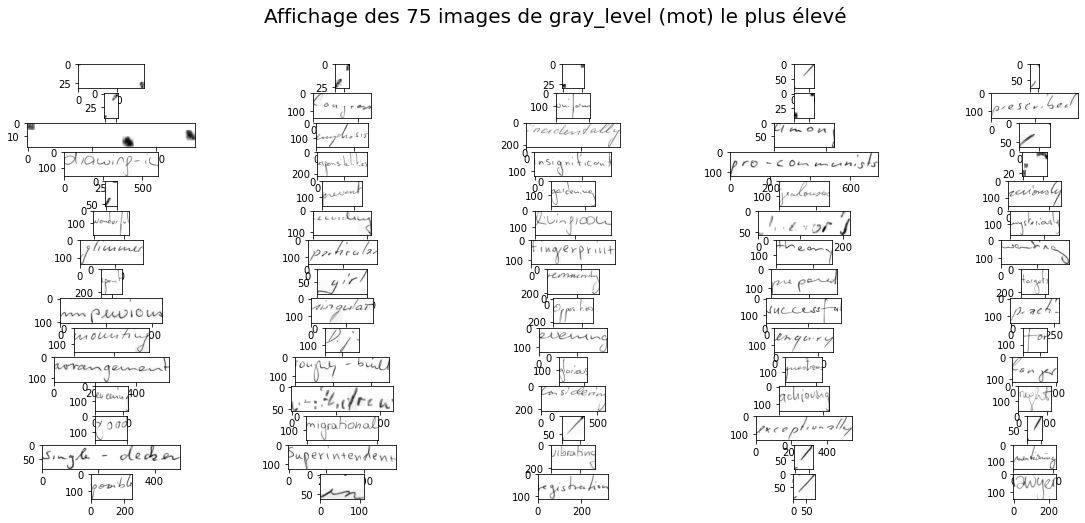

In [38]:
n_lignes = 15
n_colonnes = 5
n_images = n_lignes * n_colonnes

df_temp = df[df['seg_res']==1].sort_values(by='gray_level_mot', ascending = False, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de gray_level (mot) le plus élevé', fontsize = 20);

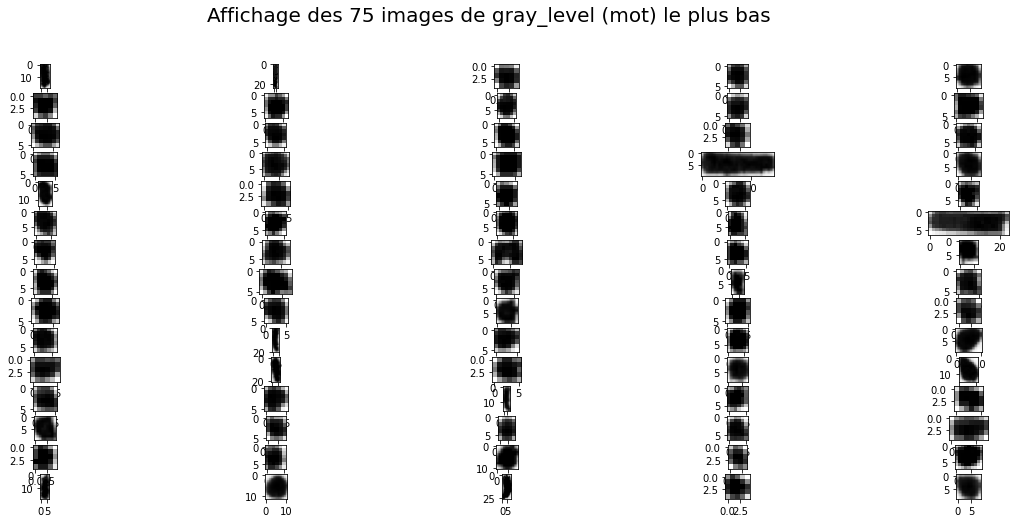

In [39]:
n_lignes = 15
n_colonnes = 5
n_images = n_lignes * n_colonnes

df_temp = df[(df['seg_res']==1) & (df['gray_level_mot']>0)].sort_values(by='gray_level_mot', ascending = True, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de gray_level (mot) le plus bas', fontsize = 20);

### Mise en relation du niveau de gris d'une ligne et d'un mot

In [40]:
from scipy.stats import pearsonr

pearsonr(df.gray_level, df.gray_level_mot)

(0.3234460869787927, 0.0)

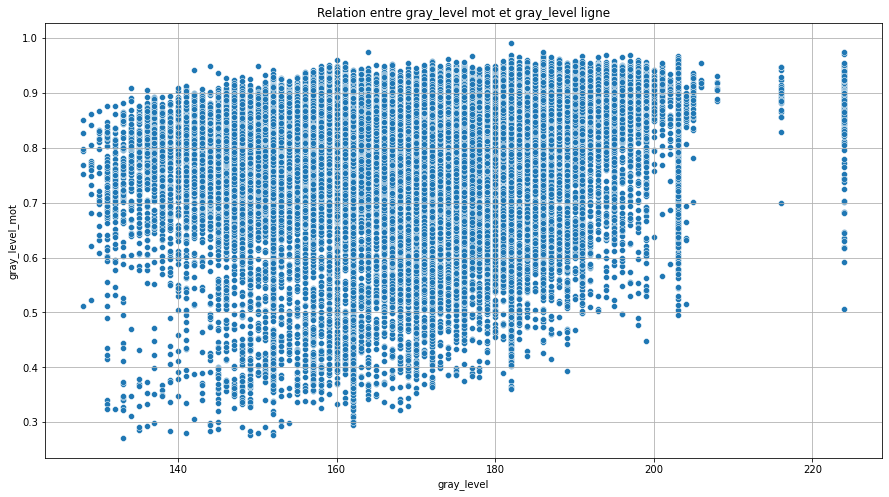

In [41]:
plt.figure(figsize = (15,8))
sns.scatterplot(data=df[df['seg_res']==1], x='gray_level', y='gray_level_mot')
plt.title('Relation entre gray_level mot et gray_level ligne')
plt.grid()

J'en déduis qu'il n'y a pas de corrélation forte entre le gray_level du mot et le gray_level de la ligne.
On observe aussi un certain nombre de mots qui on un gray level égale à 0.

## Résultats du pre-processing

In [42]:
print('Le dataset dispose de ' + str(df.shape[0]) +' mots scannés.')
print('Le dataset dispose de ' + str(df['seg_res'].value_counts()[1]) +' mots avec segmentation OK.')

Le dataset dispose de 115186 mots scannés.
Le dataset dispose de 96420 mots avec segmentation OK.


## Répartition des lettres dans le corpus

In [43]:
corpus = "".join([trans for trans in df['transcription']])

def get_letter_frequency_dict(text):
    dic = {}
    for l in text:
        if l in dic:
            dic[l] += 1
        else:
            dic[l] = 1
    return dic

freq_dict = get_letter_frequency_dict(corpus)
print(freq_dict)


{'A': 1257, 'M': 1144, 'O': 469, 'V': 171, 'E': 675, 't': 39964, 'o': 33336, 's': 27866, 'p': 8253, 'r': 27513, '.': 6179, 'G': 661, 'a': 35841, 'i': 30299, 'k': 2819, 'e': 56903, 'l': 18033, 'f': 10004, 'm': 10640, 'n': 31025, 'g': 8653, 'y': 8262, 'L': 638, 'b': 6800, 'u': 12202, 'P': 720, 'd': 17949, ' ': 49, 'w': 8807, 'c': 11823, 'h': 25242, 'F': 489, 'j': 423, 'W': 728, ',': 5614, 'x': 785, '0': 431, 'T': 1652, '-': 1545, "'": 1974, 'v': 4528, 'B': 854, 'H': 988, '"': 1596, 'S': 1064, '1': 493, '9': 179, '5': 157, '8': 118, '3': 174, '#': 79, 'q': 370, 'N': 711, 'R': 606, 'D': 569, 'K': 163, 'U': 189, 'I': 1598, '(': 202, '2': 209, ')': 199, 'C': 750, '4': 118, ':': 164, 'Y': 227, 'J': 181, '7': 64, ';': 204, '6': 121, 'z': 205, 'Z': 10, '?': 259, '*': 14, 'Q': 16, 'X': 8, '!': 225, '/': 16, '&': 55, '+': 9}


In [44]:
keys = list(freq_dict.keys())
values = list(freq_dict.values())
sorted_indexes = np.argsort(keys)
labels = []
counts = []
for index in sorted_indexes:
    labels.append(keys[index])
    counts.append(values[index])

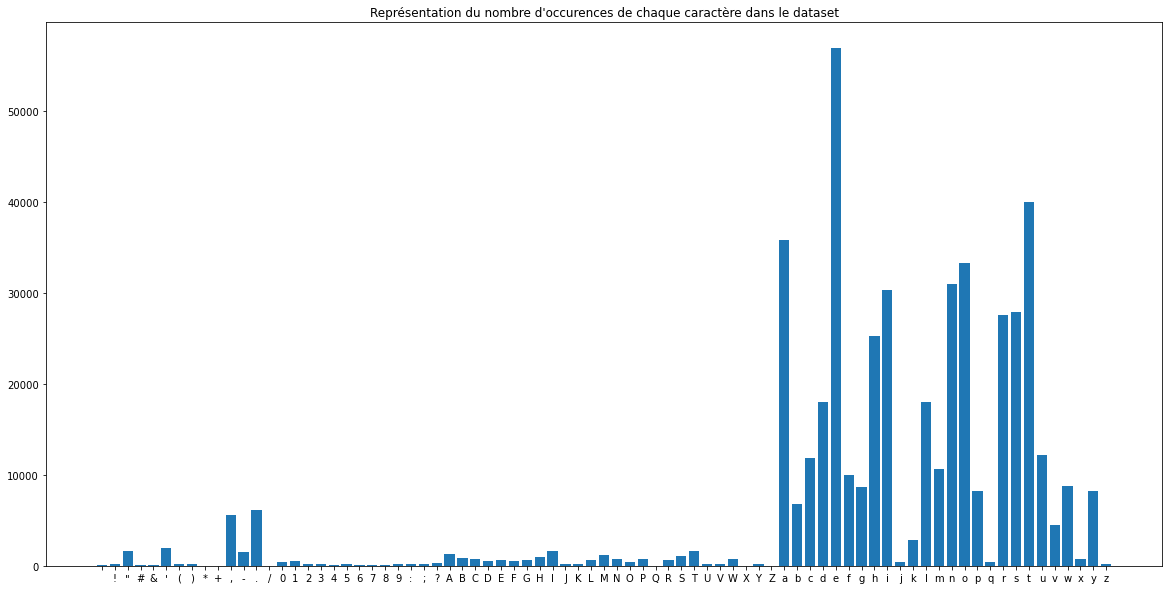

In [45]:
plt.figure(figsize=(20,10))
plt.title("Représentation du nombre d'occurences de chaque caractère dans le dataset")
plt.bar(labels, counts)
plt.show()

In [46]:
print("La lettre 'k' est représentée seulement", freq_dict['k'], "dans le corpus")
print("Tandis que la lettre 'e' est représentée", freq_dict['e'], "dans le corpus")

La lettre 'k' est représentée seulement 2819 dans le corpus
Tandis que la lettre 'e' est représentée 56903 dans le corpus


Nous pouvons observer une grosse disparité dans les représentations de chacune des lettres.
Les lettres 'j', 'k', 'q', 'x' et 'z' notamment sont très peu représentées. 

A l'inverse, les lettres 'e', 'a' et 't' sont très présentes. 



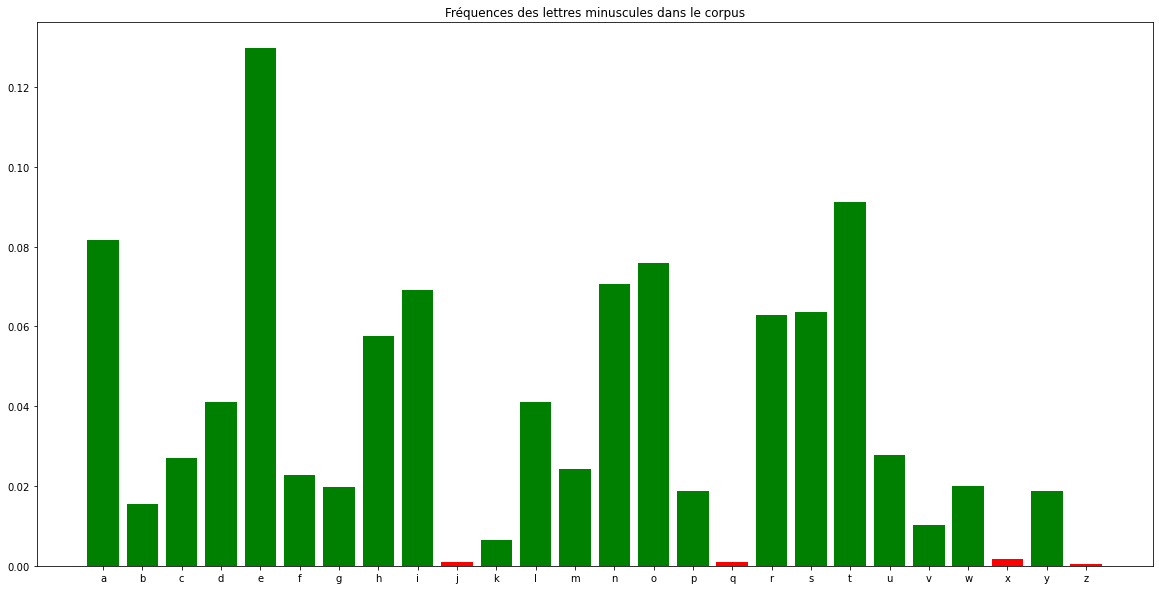

In [47]:
from functools import reduce

alphabet_start = labels.index('a')

alphabet_labels = labels[alphabet_start:]
alphabet_counts = counts[alphabet_start:]
total_alphabet_occurences = reduce(lambda a, b: a + b,  alphabet_counts)
colors = [('green' if p > 1000 else 'red') for p in alphabet_counts]

plt.figure(figsize=(20,10))
plt.title("Fréquences des lettres minuscules dans le corpus")
plt.bar(alphabet_labels, [count / total_alphabet_occurences for count in alphabet_counts], color=colors)
plt.show()

Cette distribution peut être mise en paralèlle avec la distribution des lettres dans la langue anglaise. 

En effet, notre objectif étant de créer une reconnaissance de caractères, plus notre modèle aura l'habtiude de traiter des lettres fréquentes correctement, meilleures seront nos chances de réussite, à defaut d'avoir un dataset plus conséquent.

Or, les fréquences des lettres anglaises semblent bien concordées avec la distribution de notre corpus. Le corpus est donc bien représentatif.

<img src="../images/english_letter_distribution.png" />

Source: https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html

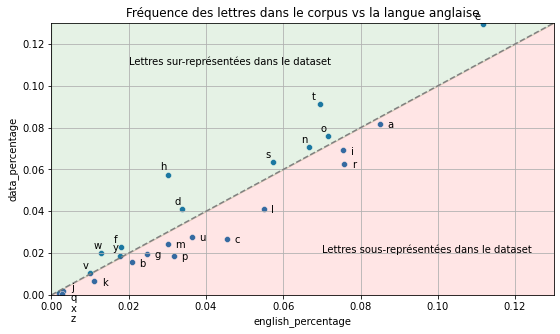

In [48]:
df_alphabet = pd.DataFrame(list(zip(alphabet_labels,alphabet_counts)), columns = ['label','data_count'])
df_alphabet['data_percentage'] = df_alphabet['data_count'] / df_alphabet['data_count'].sum()

english_labels = ['E','A','R','I','O','T','N','S','L','C','U','D','P','M','H','G','B','F','Y','W','K','V','X','Z','J','Q']
english_counts= [0.111607,0.084966,0.075809,0.075448,0.071635,0.069509,0.066544,0.057351,0.054893,0.045388,0.036308,0.033844,0.031671,0.030129,0.030034,0.024705,0.02072,0.018121,0.017779,0.012899,0.011016,0.010074,0.002902,0.002722,0.001965,0.001962]

df_alphabet_english = pd.DataFrame(list(zip(english_labels,english_counts)), columns =['label', 'english_percentage'])
df_alphabet_english.label = df_alphabet_english.label.apply(lambda x: x.lower())

df_alphabet = df_alphabet.merge(right = df_alphabet_english, on='label')


plt.figure(figsize = (9,5))
sns.scatterplot(data=df_alphabet, x='english_percentage', y='data_percentage')
plt.title('Fréquence des lettres dans le corpus vs la langue anglaise')
plt.plot([0,.14],[0,.14], ls='--', color='gray')
plt.xlim(0,.13)
plt.ylim(0,.13)
plt.grid()

j=0

for i in range(len(df_alphabet)):
    if df_alphabet.data_percentage.iloc[i] < .005:
        plt.text(x = .005, y=.002 - j * .005,s = df_alphabet.label.iloc[i])
        j+=1
    elif df_alphabet.data_percentage.iloc[i] >= df_alphabet.english_percentage.iloc[i]:
        plt.text(x = (df_alphabet.english_percentage.iloc[i] - .002), y=(df_alphabet.data_percentage.iloc[i] + .002), s = df_alphabet.label.iloc[i])
    else :
        plt.text(x = (df_alphabet.english_percentage.iloc[i] + .002), y=(df_alphabet.data_percentage.iloc[i] - .002), s = df_alphabet.label.iloc[i])


plt.fill_between(x=[0,.14], y1=[0,0], y2=[0,.14],alpha = .1, color='red')
plt.fill_between(x=[0,.14], y1=[0,.14], y2=[.14,.14],alpha = .1, color='green')

plt.text(x=.07, y=.02,s='Lettres sous-représentées dans le dataset');
plt.text(x=.02,y=.11,s='Lettres sur-représentées dans le dataset');

On peut par contre se demander comment réagirait notre modèle à une autre langue dont la répartition des lettres serait différente.

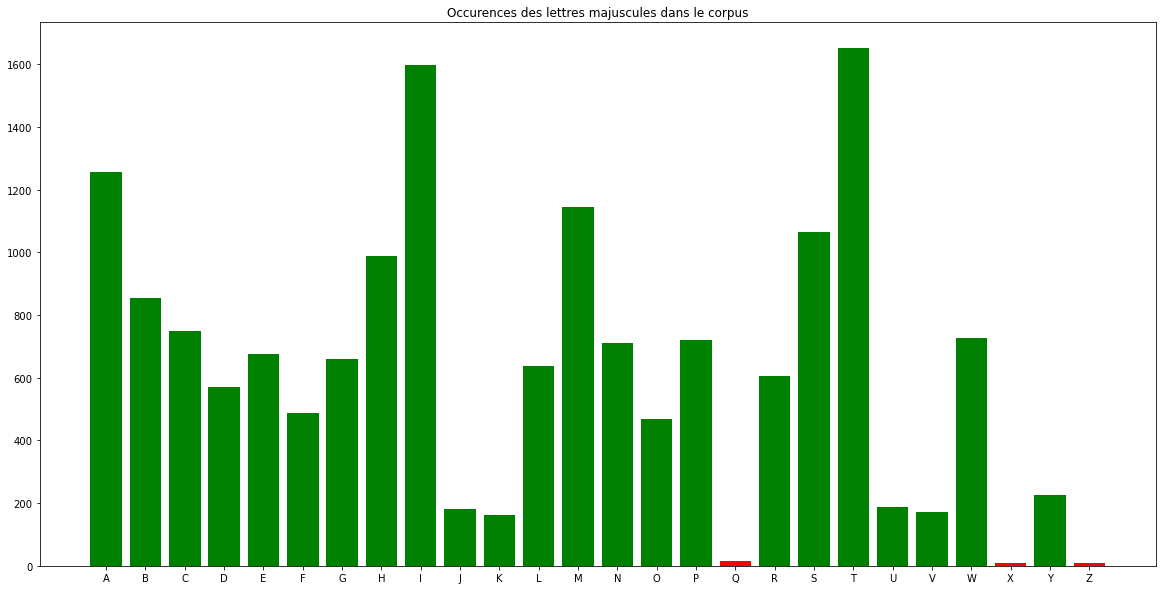

In [49]:
from functools import reduce

alphabet_start = labels.index('A')
alphabet_end = labels.index('Z')

alphabet_labels = labels[alphabet_start:alphabet_end++1]
alphabet_counts = counts[alphabet_start:alphabet_end+1]
total_alphabet_occurences = reduce(lambda a, b: a + b,  alphabet_counts)
colors = [('green' if p > 100 else 'red') for p in alphabet_counts]

plt.figure(figsize=(20,10))
plt.title("Occurences des lettres majuscules dans le corpus")
plt.bar(alphabet_labels, [count for count in alphabet_counts], color=colors)
plt.show()

On remarque cependant une sous représentation des majuscules dans le dataset. Les représentations des majuscules étant radicalement différentes des minuscules, il se peut que notre modèle manque de données d'entraînement pour, par la suite, bien distinguer des majuscules.

### Longueur des mots

In [50]:
total_word_length = 0
number_words = 0
biggest_word_length = 0
biggest_word = None
all_words = []
for text in df['transcription']:
    words = text.split(' ')
    for word in words:
        all_words.append(word)
        l = len(word)
        if l > biggest_word_length:
            biggest_word_length = l
            biggest_word = word
        total_word_length += l
    number_words += len(words) 

print("Le mot le plus long est", biggest_word, "avec", biggest_word_length, "caractères")


Le mot le plus long est ----------------------------------------------------- avec 53 caractères


## Position et taille des boîtes

```
file n06-128.png
```

Output:
`n06-128.png: PNG image data, 2479 x 3542, 8-bit grayscale, non-interlaced`


### Position des boîtes

In [51]:
df[(df['x'] == -1) | (df['y'] == -1) | (df['h'] == -1) | (df['w'] == -1)].head()

Empty DataFrame
Columns: [word_id, seg_res, gray_level, x, y, w, h, tag, transcription, word_img_path, form_img_path, michelson_contrast, gray_level_mot]
Index: []

Il ne reste plus de mots dont le positionnement n'a pas été trouver. Nous pouvons donc analyser la répartition des boîtes dans notre dataset.

In [52]:
print(df['x'].max())
print(df['y'].max())

2471
2792


In [53]:
def show_text_position_over_dataset():
    arr = np.zeros((3542, 2479))
    for index, row in df.iterrows():
        x = row.x
        y = row.y
        arr[y][x] += 1
        for i in range(row.h):
            for j in range(row.w):
                arr[y + i][x + j] += 1

    plt.figure(figsize=(20,10))
    plt.imshow(arr);

# Need ten minutes to run
#show_text_position_over_dataset()

<img src="../images/text_box_position.png">

### Taille des boîtes

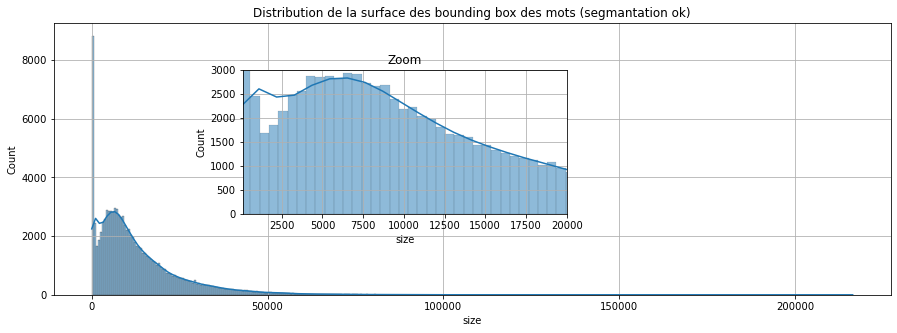

In [54]:
df['size'] = df.h * df.w

plt.figure(figsize = (15,5))
sns.histplot(data = df[df.seg_res==1], x= 'size', kde = True)
plt.title('Distribution de la surface des bounding box des mots (segmantation ok)')
plt.grid()

a = plt.axes([.3, .35, .3, .4])
sns.histplot(data = df[df.seg_res==1], x= 'size', kde = True)
plt.title('Zoom')
plt.xlim((100,20000))
plt.ylim((0,3000))
plt.grid();

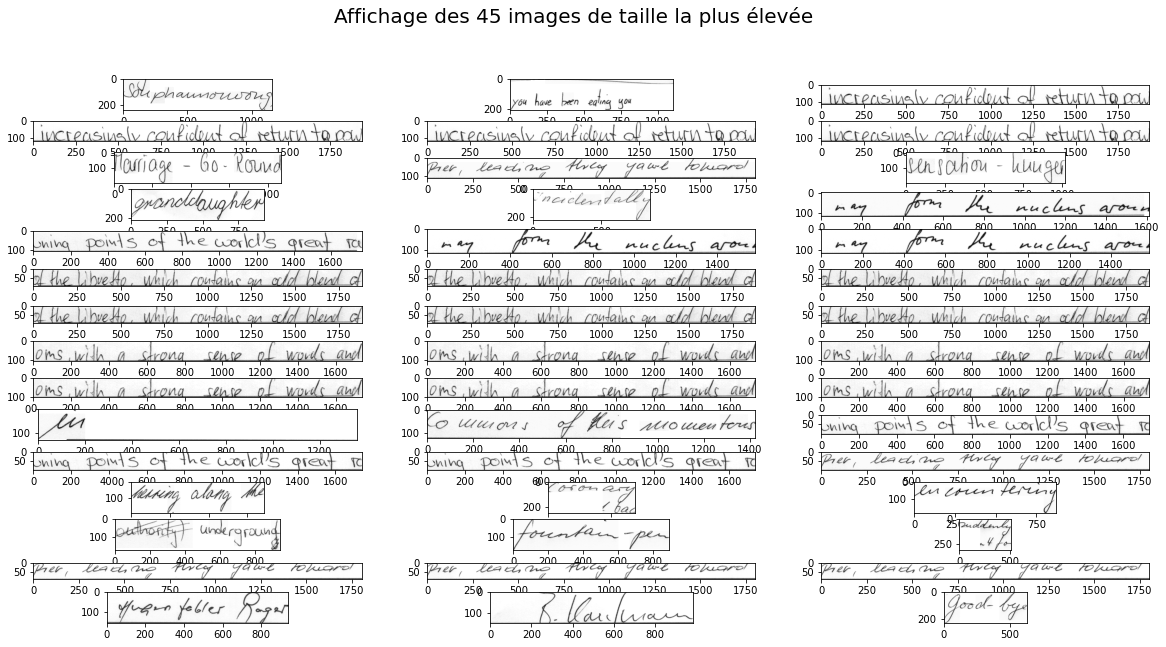

In [55]:
df['size'] = df.h * df.w

n_lignes = 15
n_colonnes = 3
n_images = n_lignes * n_colonnes

df_temp = df.sort_values(by='size', ascending = False, ignore_index=True)

fig = plt.figure(figsize = (20,10))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de taille la plus élevée', fontsize = 20);

Ce résultat montre qu'il y a des mots mal segmentés. Besoin de trier uniquement sur les mots avec seg_res == 1.

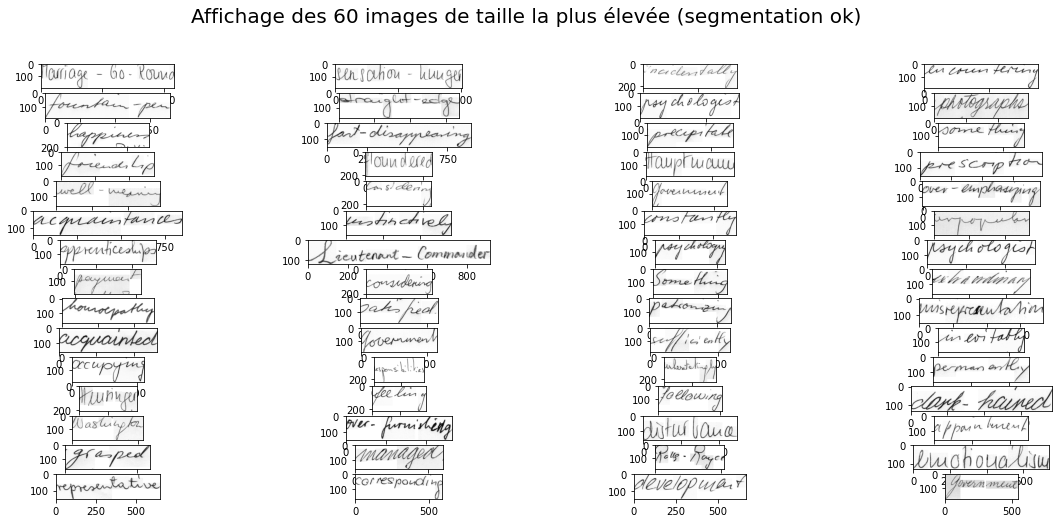

In [56]:
df['size'] = df.h * df.w

n_lignes = 15
n_colonnes = 4
n_images = n_lignes * n_colonnes

df_temp = df[df['seg_res']==1].sort_values(by='size', ascending = False, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de taille la plus élevée (segmentation ok)', fontsize = 20);

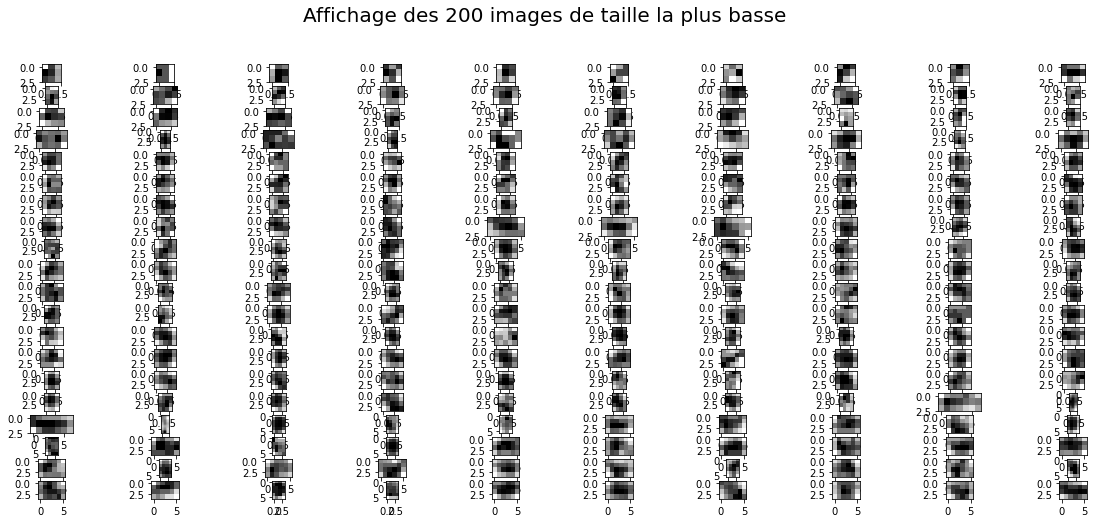

In [57]:
df['size'] = df.h * df.w

n_lignes = 20
n_colonnes = 10
n_images = n_lignes * n_colonnes

df_temp = df.sort_values(by='size', ascending = True, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de taille la plus basse', fontsize = 20);

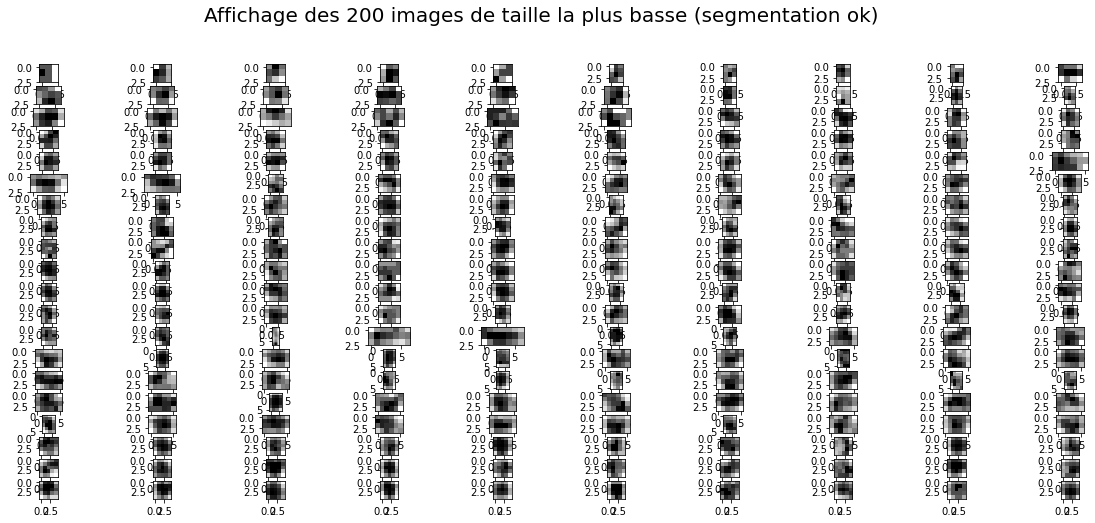

In [58]:
df['size'] = df.h * df.w

n_lignes = 20
n_colonnes = 10
n_images = n_lignes * n_colonnes

df_temp = df[df['seg_res']==1].sort_values(by='size', ascending = True, ignore_index=True)

fig = plt.figure(figsize = (20,8))

for i in range(n_images):
    fig.add_subplot(n_lignes,n_colonnes,i+1)
    plt.imshow(plt.imread(get_word_image_path_by_word_id(df_temp.word_id.iloc[i])), cmap = 'gray')
    
fig.suptitle(t = 'Affichage des ' + str(n_images) + ' images de taille la plus basse (segmentation ok)', fontsize = 20);

## Styles d'écriture

Nous pouvons également nous intéresser aux différents styles d'écriture pouvant influencés la représentation d'une lettre. 

Nous pouvons supposer que chacun des auteurs a un style d'écriture qui lui est propre et nous intéresser aux nombres de styles existants pour chacune des lettres. 

Il serait par ailleurs peut être intéressant par la suite de générer des textes ayant différentes polices d'écriture pour diversifier davantage les représentations possibles d'une lettre.

In [59]:
def parse_my_form_file(filename):
    with open(filename) as f:
        for line in f:
            if line.startswith('#'):
                continue
            yield line.strip().split(' ')

In [60]:
#Analyse des fichiers xml sur les forms

#Récupérer tous les mots d'un form
def get_words_from_xml_form(filepath):
    words = []
    tree = etree.parse(filepath)
    for word in tree.xpath("/form/handwritten-part/line/word"):
        words.append(word.get('text'))
    return words

In [61]:
# parcours de tous les fichiers d'un dossier et ses sous-dossiers, possibilité de spécifier une extension et la recherche parmis les sous dossiers
def get_files(path, ext='', sub=False):
    if sub == True:
        path = path + '/**'     
    if ext != '':
        path = path + '/*.' + ext
    else:
        path = path + '/*.*'  # le . filtre les dossiers  
    files = glob.glob(path, recursive=sub)
    return files

In [62]:
forms_columns = ['form_id', 'writer_id', 'number_of_sentences', 'word_seg', 'total_lines', 'correct_lines', 'total_words', 'correct_words']
form_df = pd.DataFrame(parse_my_form_file(forms_meta_filename), columns=forms_columns)
form_df.head(10)

form_id writer_id number_of_sentences word_seg total_lines correct_lines  \
0  a01-000u       000                   2      prt           7             5   
1  a01-000x       001                   2      all           6             6   
2   a01-003       002                   3      prt          11            10   
3  a01-003u       000                   3      prt          11            10   
4  a01-003x       003                   3      prt           9             6   
5   a01-007       004                   3      all           9             9   
6  a01-007u       000                   3      all          10            10   
7  a01-007x       003                   3      all           8             8   
8   a01-011       005                   2      prt           7             6   
9  a01-011u       000                   2      all          10            10   

  total_words correct_words  
0          52            36  
1          52            52  
2          81            71  
3          80            73  
4          82            56  
5          69            69  
6          68            68  
7          69            69  
8          68            58  
9          68            68

In [63]:
count_per_writer_df = form_df[['writer_id', 'form_id']].groupby("writer_id").count()
count_per_writer_df.columns = ['nb_forms']
count_per_writer_df.head()


nb_forms
writer_id          
000              59
001               2
002               1
003               2
004               1

In [64]:
count_per_writer_df.describe()

nb_forms
count  657.000000
mean     2.342466
std      3.033337
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     59.000000

On remarque une moyenne de 2.34 forms par auteur et un écart moyen de l'ordre de 3 avec un minimum de 1 et un maximum de 59: Il semble donc y avoir un/des outliers.

In [65]:
max_nb_forms_per_author = count_per_writer_df['nb_forms'].max()
count_per_writer_df[count_per_writer_df['nb_forms'] == max_nb_forms_per_author]

nb_forms
writer_id          
000              59

L'auteur ayant l'identifiant 000 semble indiquer un auteur inconnu.

In [66]:
count_per_writer_df = count_per_writer_df[count_per_writer_df['nb_forms'] < max_nb_forms_per_author]
count_per_writer_df.describe()

nb_forms
count  656.000000
mean     2.256098
std      2.075291
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     10.000000

En moyenne, un auteur est responsable de 2.25 forms.

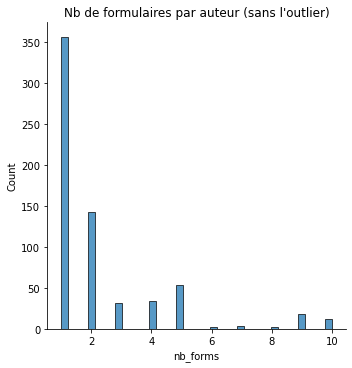

Nombre total :  656
Nombre de 3+ :  158
Nombre de 5+ :  92


In [67]:


sns.displot(x="nb_forms", data=count_per_writer_df[count_per_writer_df['nb_forms'] < 50])
plt.title("Nb de formulaires par auteur (sans l'outlier)")
plt.show()

print('Nombre total : ', count_per_writer_df.shape[0])
print('Nombre de 3+ : ', count_per_writer_df[count_per_writer_df["nb_forms"] >= 3].shape[0])
print('Nombre de 5+ : ', count_per_writer_df[count_per_writer_df["nb_forms"] >= 5].shape[0])


La répartition du nombre de formulaires écrits par auteur n'est pas uniforme, il faudra donc être prudent lors de la création des ensembles de training, validation et test (ne prendre qu'un seul formulaire par auteur pour chaque ensemble par ex)

In [68]:
#Chargement des informations depuis les fichiers xml (un xml par form)
all_files = get_files(xml_files_path, ext='xml', sub=True)
all_words = []
for file in all_files:
    all_words.extend(get_words_from_xml_form(file))
all_letters = []
for word in all_words:
    all_letters.extend(list(word))
all_letters.sort()    

print('Nombre de forms chargés : ',len(all_files))
print('Nombre de mots chargés : ', len(all_words))
print('Nombre de lettres chargées : ', len(all_letters))


Nombre de forms chargés :  1539
Nombre de mots chargés :  115320
Nombre de lettres chargées :  475702


In [69]:
# creation d'un dataframe wavec tous les mots et leur longueur
df_words = pd.DataFrame(all_words, columns=['words'])
df_words['len'] = df_words['words'].apply(lambda w: len(w))

print('Mot pourri : ', df_words['words'][df_words['len'] == 53])
#suppression du "faux" mot pour meilleure visu
df_words2 = df_words.drop(index=107040)


Mot pourri :  82300    ----------------------------------------------...
Name: words, dtype: object


Nombre de mots différents :  13550
Nombre de mots vues une seule fois :  7190
Nombre de mots vues 1000+ fois :  11


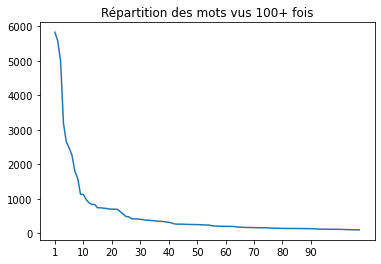

In [70]:
#Répartition des mots

df_words_count = pd.DataFrame(Counter(df_words2['words']).keys(), columns=['words'])
df_words_count['count'] = Counter(df_words2['words']).values()
df_words_count.sort_values(by='count', inplace=True, ascending=False)

print('Nombre de mots différents : ', len(df_words2['words'].unique()));
print('Nombre de mots vues une seule fois : ', len(df_words_count['count'][df_words_count['count'] == 1]));
print('Nombre de mots vues 1000+ fois : ', len(df_words_count['count'][df_words_count['count'] >= 1000]));

# df_words_count.head(20)
# ax = plt.gca()
# ax.axes.xaxis.set_visible(False)

plt.plot(df_words_count['words'][df_words_count['count'] > 100], df_words_count['count'][df_words_count['count'] > 100])
plt.xticks(np.arange(0, 100, 10), ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90'])
plt.title('Répartition des mots vus 100+ fois');



Beaucoup de mots ne sont vus qu'une seule fois, d'autres sont vus de très nombreuses fois, attention à l'overfitting

Nombre total de lettres :  475700
Nombre moyen de lettres par mot:  4.125079128330977


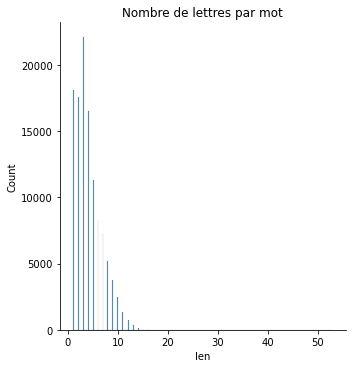

In [71]:
# Nombre de lettres par mot
sns.displot(df_words2['len'], kind = 'hist')
plt.title('Nombre de lettres par mot');

print('Nombre total de lettres : ', df_words2['len'].sum())
print('Nombre moyen de lettres par mot: ', df_words2['len'].mean())

In [72]:
df['form_id'] = df['word_id'].apply(lambda x: '-'.join(x.split('-')[:2]))
df.head()

word_id  seg_res  gray_level     x    y    w   h  tag transcription  \
0  a01-000u-00-00        1         154   408  768   27  51   AT             A   
1  a01-000u-00-01        1         154   507  766  213  48   NN          MOVE   
2  a01-000u-00-02        1         154   796  764   70  50   TO            to   
3  a01-000u-00-03        1         154   919  757  166  78   VB          stop   
4  a01-000u-00-04        1         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png   

                   form_img_path  michelson_contrast  gray_level_mot   size  \
0  ../data/formsA-D/a01-000u.png            0.805755        0.530155   1377   
1  ../data/formsA-D/a01-000u.png            0.808511        0.735608  10224   
2  ../data/formsA-D/a01-000u.png            0.814947        0.713311   3500   
3  ../data/formsA-D/a01-000u.png            0.847826        0.825912  12948   
4  ../data/formsA-D/a01-000u.png            0.875000        0.789901   7686   

    form_id  
0  a01-000u  
1  a01-000u  
2  a01-000u  
3  a01-000u  
4  a01-000u

In [73]:
df = pd.merge(left=df, right=form_df, on='form_id', how='left')
df.head()

word_id  seg_res  gray_level     x    y    w   h  tag transcription  \
0  a01-000u-00-00        1         154   408  768   27  51   AT             A   
1  a01-000u-00-01        1         154   507  766  213  48   NN          MOVE   
2  a01-000u-00-02        1         154   796  764   70  50   TO            to   
3  a01-000u-00-03        1         154   919  757  166  78   VB          stop   
4  a01-000u-00-04        1         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  ... gray_level_mot   size  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png  ...       0.530155   1377   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png  ...       0.735608  10224   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png  ...       0.713311   3500   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png  ...       0.825912  12948   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png  ...       0.789901   7686   

    form_id  writer_id number_of_sentences word_seg total_lines correct_lines  \
0  a01-000u        000                   2      prt           7             5   
1  a01-000u        000                   2      prt           7             5   
2  a01-000u        000                   2      prt           7             5   
3  a01-000u        000                   2      prt           7             5   
4  a01-000u        000                   2      prt           7             5   

  total_words correct_words  
0          52            36  
1          52            36  
2          52            36  
3          52            36  
4          52            36  

[5 rows x 22 columns]

In [74]:
print(df.columns)

Index(['word_id', 'seg_res', 'gray_level', 'x', 'y', 'w', 'h', 'tag',
       'transcription', 'word_img_path', 'form_img_path', 'michelson_contrast',
       'gray_level_mot', 'size', 'form_id', 'writer_id', 'number_of_sentences',
       'word_seg', 'total_lines', 'correct_lines', 'total_words',
       'correct_words'],
      dtype='object')


In [75]:
letter_writers_dict = {}
for index, row in df.iterrows():
    writer_id = str(row['writer_id'])
    for letter in row['transcription']:
        if letter != ' ':
            if letter not in letter_writers_dict:
                letter_writers_dict[letter] = [writer_id]
            else:
                if writer_id not in letter_writers_dict[letter]:
                    letter_writers_dict[letter].append(writer_id)


In [76]:
keys = list(letter_writers_dict.keys())
sorted_indexes = np.argsort(keys)
values = [len(letter_writers_dict[key]) for key in keys]
labels = []
counts = []
for index in sorted_indexes:
    labels.append(keys[index])
    counts.append(values[index])

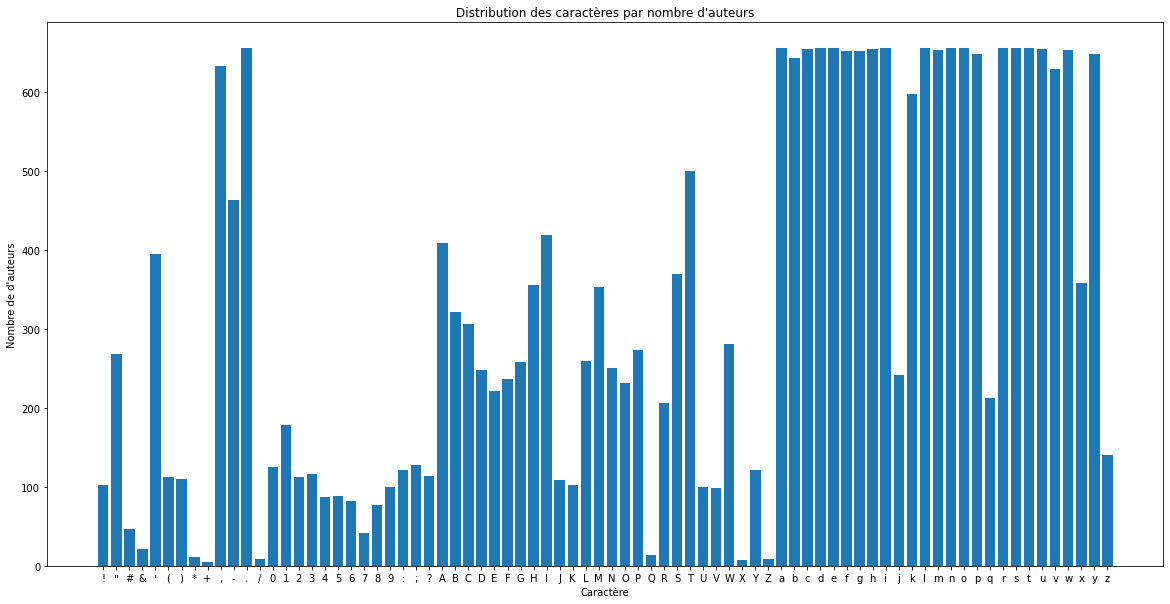

In [77]:
plt.figure(figsize=(20,10))
plt.title("Distribution des caractères par nombre d'auteurs")
plt.bar(x=labels, height=counts)
plt.xlabel('Caractère')
plt.ylabel("Nombre de d'auteurs")
plt.show()

Comme on pouvait s'y attendre, les lettres minuscules sont presque toutes au moins une fois représentées par un auteur. 

Nous voyons cependant que les lettres majuscules peuvent poser problème car elles ne sont parfois représentées que par moins de 100 auteurs différents.

Nous aurions pu également compter le nombre d'occurences de ces lettres pour chaque auteur afin de nous assurer qu'un style ne domine pas sur les autres car majoritairement représenté. 

Toutefois, l'impact d'une surreprésentation devrait pouvoir être négligé car les textes comportent tous un bon nombre de lettres différentes.

## Luminance

In [78]:
from PIL import Image

img = Image.open(df.iloc[0].word_img_path)
#Convert the image te RGB if it is a .gif for example
img = img.convert ('RGB')
#coordinates of the pixel
X,Y = 0,0
#Get RGB
pixelRGB = img.getpixel((X,Y))
R,G,B = pixelRGB 

brightness = sum([R,G,B])/3
brightness

249.0

## Détection des contours

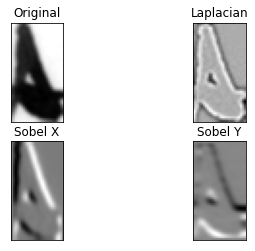

In [79]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



img_arr = cv2.imread(df.iloc[0].word_img_path)
gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(gray,(3,3),0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=5)  
sobely = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=5)  


plt.subplot(2,2,1),
plt.imshow(img,cmap = 'gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,2),
plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y')
plt.xticks([])
plt.yticks([])

plt.show()

../data/words/a01/a01-030/a01-030-00-08.png


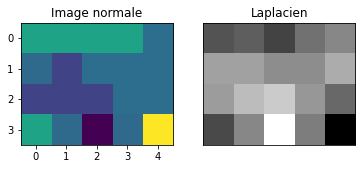

In [80]:
def get_laplacian_img_for_row(row):
    img_arr = cv2.imread(row.word_img_path)
    gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    return cv2.Laplacian(img,cv2.CV_64F)



bad_contrast_row = df[df['michelson_contrast'] <= 0.2].iloc[0]
laplacian_bad_constrast = get_laplacian_img_for_row(bad_contrast_row)
print(bad_contrast_row.word_img_path)

plt.subplot(1,2,1),
plt.title('Image normale')
plt.imshow(plt.imread(bad_contrast_row.word_img_path));
plt.subplot(1,2,2),
plt.imshow(laplacian_bad_constrast,cmap = 'gray');
plt.title('Laplacien')
plt.xticks([])
plt.yticks([])
plt.show()


In [81]:
first_writer_df = df[df['writer_id'] == '000']
print(len(first_writer_df))
print(len(df))

4221
115186


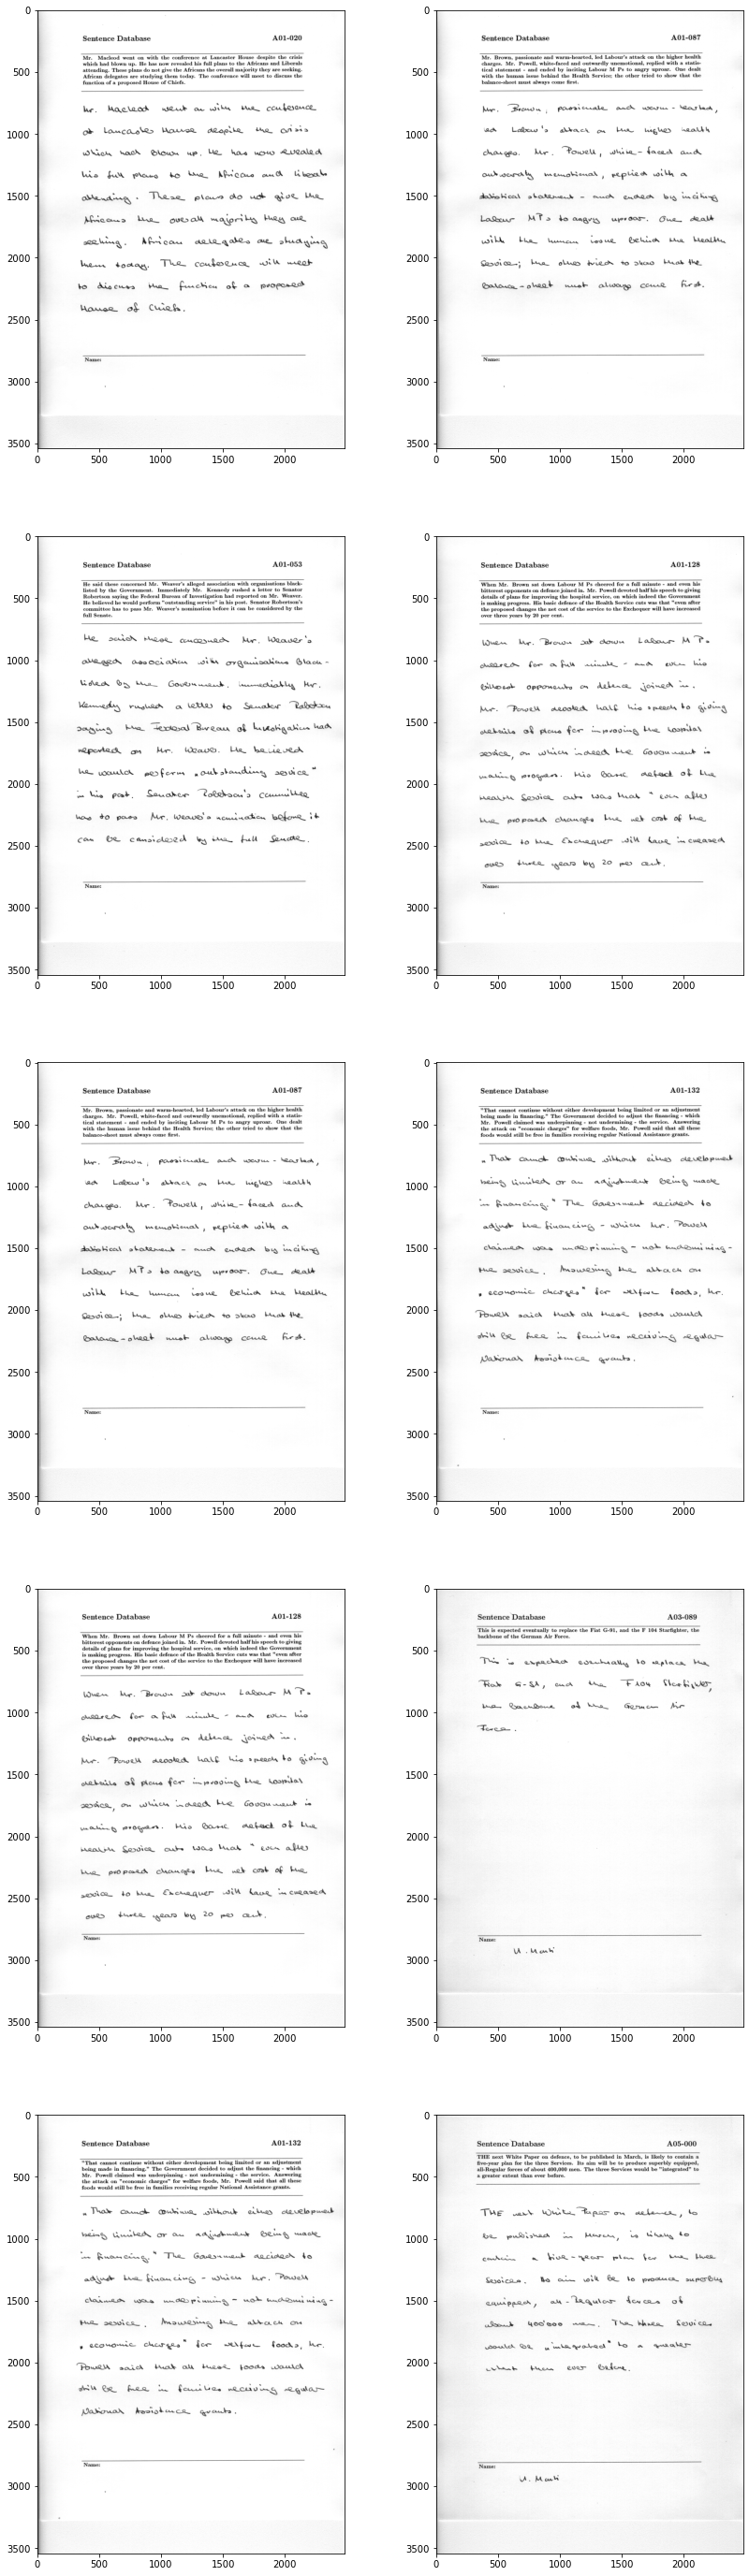

In [82]:
n_rows = 5
n_col = 2
n_images = n_rows * n_col
rand_list = np.sort(np.random.randint(0, first_writer_df.shape[0], n_images))


fig, ax = plt.subplots(n_rows,n_col, figsize=(14,50))
for i in range(n_rows):
    for j in range(n_col):
        img = plt.imread(get_form_img_path_by_word_id(first_writer_df.word_id.iloc[rand_list[i+ j * n_col]]))
        ax[i, j].imshow(img, cmap = 'gray') ;

In [83]:
df.head()

word_id  seg_res  gray_level     x    y    w   h  tag transcription  \
0  a01-000u-00-00        1         154   408  768   27  51   AT             A   
1  a01-000u-00-01        1         154   507  766  213  48   NN          MOVE   
2  a01-000u-00-02        1         154   796  764   70  50   TO            to   
3  a01-000u-00-03        1         154   919  757  166  78   VB          stop   
4  a01-000u-00-04        1         154  1185  754  126  61  NPT           Mr.   

                                   word_img_path  ... gray_level_mot   size  \
0  ../data/words/a01/a01-000u/a01-000u-00-00.png  ...       0.530155   1377   
1  ../data/words/a01/a01-000u/a01-000u-00-01.png  ...       0.735608  10224   
2  ../data/words/a01/a01-000u/a01-000u-00-02.png  ...       0.713311   3500   
3  ../data/words/a01/a01-000u/a01-000u-00-03.png  ...       0.825912  12948   
4  ../data/words/a01/a01-000u/a01-000u-00-04.png  ...       0.789901   7686   

    form_id  writer_id number_of_sentences word_seg total_lines correct_lines  \
0  a01-000u        000                   2      prt           7             5   
1  a01-000u        000                   2      prt           7             5   
2  a01-000u        000                   2      prt           7             5   
3  a01-000u        000                   2      prt           7             5   
4  a01-000u        000                   2      prt           7             5   

  total_words correct_words  
0          52            36  
1          52            36  
2          52            36  
3          52            36  
4          52            36  

[5 rows x 22 columns]

In [85]:
for index in range(30):
    path = df.iloc[index].form_img_path
    img = plt.imread(path)
    print(img.shape)

(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
(3542, 2479)
